In [1]:
from pandas import Series, DataFrame
import pandas as pd
import re
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv("bgg_db_2018_01.csv")
print df.shape
df.head()

(4999, 20)


,rank,bgg_url,game_id,names,min_players,max_players,avg_time,min_time,max_time,year,avg_rating,geek_rating,num_votes,image_url,age,mechanic,owned,category,designer,weight
0,1,https://boardgamegeek.com/boardgame/174430/glo...,174430,Gloomhaven,1,4,150,90,150,2017,9.01310,8.52234,9841,https://cf.geekdo-images.com/images/pic2437871...,12,"Action / Movement Programming, Co-operative Pl...",18217,"Adventure, Exploration, Fantasy, Fighting, Min...",Isaac Childres,3.7720
1,2,https://boardgamegeek.com/boardgame/161936/pan...,161936,Pandemic Legacy: Season 1,2,4,60,60,60,2015,8.66575,8.49837,23489,https://cf.geekdo-images.com/images/pic2452831...,13,"Action Point Allowance System, Co-operative Pl...",38105,"Environmental, Medical","Rob Daviau, Matt Leacock",2.8056
2,3,https://boardgamegeek.com/boardgame/182028/thr...,182028,Through the Ages: A New Story of Civilization,2,4,240,180,240,2015,8.65702,8.32401,10679,https://cf.geekdo-images.com/images/pic2663291...,14,"Action Point Allowance System, Auction/Bidding...",14147,"Card Game, Civilization, Economic",Vlaada Chv�til,4.3538
3,4,https://boardgamegeek.com/boardgame/12333/twil...,12333,Twilight Struggle,2,2,180,120,180,2005,8.35188,8.21012,29923,https://cf.geekdo-images.com/images/pic361592.jpg,13,"Area Control / Area Influence, Campaign / Batt...",41094,"Modern Warfare, Political, Wargame","Ananda Gupta, Jason Matthews",3.5446
4,5,https://boardgamegeek.com/boardgame/167791/ter...,167791,Terraforming Mars,1,5,120,120,120,2016,8.38331,8.17328,20468,https://cf.geekdo-images.com/images/pic3536616...,12,"Card Drafting, Hand Management, Tile Placement...",26145,"Economic, Environmental, Industry / Manufactur...",Jacob Fryxelius,3.2465


## Dataset cleaning

### Analyzing avg_rating and geek_rating variable

In [3]:
#Excluding boardgames which do not have atleast than 100 votes
df = df[df['num_votes']>=100]
#df = df[df['min_players']>0 & df['max_players']>=0 ]
print df.shape
print df['avg_rating'].quantile([0.5,0.75,0.95,0.99])

#creating detractors and promoters for avg_rating (since its a survey result)
conditions = [
    (df['avg_rating'] <= df['avg_rating'].quantile(0.95)),
    (df['avg_rating'] > df['avg_rating'].quantile(0.95))]
choices = ['detractors', 'promoters']
df['avg_rating_range'] = np.select(conditions, choices)
print df['avg_rating_range'].value_counts()

#creating detractors and promoters for geek_rating (since its a survey result)
conditions = [
    (df['geek_rating'] <= df['geek_rating'].quantile(0.95)),
    (df['geek_rating'] > df['geek_rating'].quantile(0.95))]
choices = ['detractors', 'promoters']
df['geek_rating_range'] = np.select(conditions, choices)
df['geek_rating_range'].value_counts()

(4903, 20)
0.50    6.883800
0.75    7.305275
0.95    7.929081
0.99    8.326149
Name: avg_rating, dtype: float64
detractors    4657
promoters      246
Name: avg_rating_range, dtype: int64


detractors    4657
promoters      246
Name: geek_rating_range, dtype: int64

## EDA

### Number of players

Text(0.5,0,'Min_players')

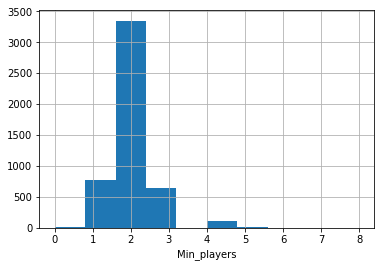

In [4]:
df['min_players'].hist()
xlabel('Min_players')

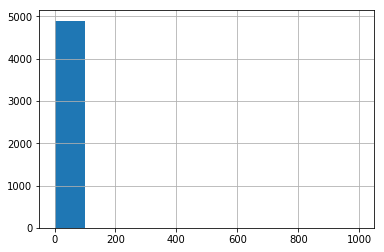

In [5]:
#max_players has a long tail
df['max_players'].hist()

Text(0.5,0,'Max players')

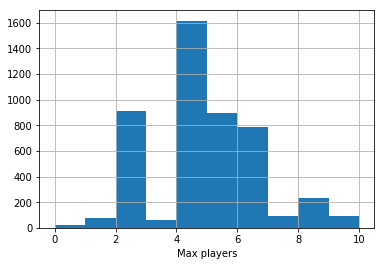

In [6]:
#checking the popular categories by condensing the tail
dfx = df[df['max_players']<=10]
dfx['max_players'].hist()
xlabel("Max players") #peak at 4 and 6

In [7]:
#creating categories single player, and multiplayer 0-2,1-2, 1-4, 1-6,1-8,>8 based on histograms
conditions = [
    (df['min_players'] <= 1) & (df['max_players'] <= 1) ,
    (df['min_players'] <= 1) & (df['max_players'] <= 2) ,
    (df['min_players'] <= 1) & (df['max_players'] <= 4) ,
    (df['min_players'] <= 1) & (df['max_players'] <= 6) ,
    (df['min_players'] <= 1) & (df['max_players'] <= 8) ,
    (df['min_players'] == 2) & (df['max_players'] <= 2) ,
    (df['min_players'] == 2) & (df['max_players'] <= 4) ,
    (df['min_players'] == 2) & (df['max_players'] <= 6) ,
    (df['min_players'] == 2) & (df['max_players'] <= 8) ,
    (df['min_players'] > 2) & (df['max_players'] <= 4) ,
    (df['min_players'] > 2) & (df['max_players'] <= 6) ,
    (df['min_players'] > 2) & (df['max_players'] <= 8) ,
    (df['max_players'] > 8) ,
]
choices = ['single_player', 'a','b','c','d','two_player','f','g','h','i','j','k','l']
df['num_players'] = np.select(conditions, choices)
df['num_players'].value_counts()

# Key:
# a: 1 to 2
# b: 1 to 4
# c: 1 to 6
# d: 1 to 8
# f: 2 to 4
# g: 2 to 6
# h: 2 to 8
# i: 2+ to 4
# j: 2+ to 6
# k: 2+ to 8
# l: 8+

f                1244
g                1047
two_player        799
j                 433
b                 316
l                 214
c                 206
h                 175
a                 122
i                 121
k                 111
single_player      81
d                  34
Name: num_players, dtype: int64

In [8]:
#Checking avg_rating and geek_rating NPS for player range
cdf = df.groupby(['num_players','avg_rating_range'])['game_id'].count().unstack()
cdf['NPS'] = cdf['promoters']/246 - cdf['detractors']/4657
print cdf.sort_values('NPS',ascending = False)
cdf.to_csv("num_players.csv")
cdf = df.groupby(['num_players','geek_rating_range'])['game_id'].count().unstack()
cdf['NPS'] = cdf['promoters']/246 - cdf['detractors']/4657
cdf.sort_values('NPS',ascending = False)

#two player games are most popular followed by 1 to 4 players
# Key:
# a: 1 to 2
# b: 1 to 4
# c: 1 to 6
# d: 1 to 8
# f: 2 to 4
# g: 2 to 6
# h: 2 to 8
# i: 3+ to 4
# j: 3+ to 6
# k: 3+ to 8
# l: 8+


avg_rating_range  detractors  promoters       NPS
num_players                                      
two_player               731         68  0.119455
b                        274         42  0.111896
a                        100         22  0.067958
single_player             70         11  0.029684
c                        191         15  0.019962
d                         32          2  0.001259
k                        108          3 -0.010996
h                        169          6 -0.011899
i                        119          2 -0.017423
l                        208          6 -0.020274
j                        429          4 -0.075859
f                       1200         44 -0.078815
g                       1026         21 -0.134948


IOError: [Errno 13] Permission denied: 'num_players.csv'

### Average time

In [ ]:
#Average time
print df['avg_time'].describe()
print df['avg_time'].quantile([0.5,0.75,0.95,0.99])
#df['avg_time'].hist()

dfx = df[df['avg_time']<=720]
dfx['avg_time'].hist()
xlabel("Avg Time") #peak at 4 and 6
print dfx['avg_time'].describe()
print dfx['avg_time'].quantile([0.5,0.75,0.95,0.99])

In [ ]:
#Bucketing avg_time into 5 buckets:
# Longer games are more popular
df['avg_time_bucket'] = pd.qcut(df['avg_time'],8)
cdf = df.groupby(['avg_time_bucket','avg_rating_range'])['game_id'].count().unstack()
cdf['NPS'] = cdf['promoters']/246 - cdf['detractors']/4657
cdf.to_csv("avg_time.csv")
cdf.sort_values('avg_time_bucket',ascending = True)


#cdf = pd.crosstab(df['avg_time_bucket'],df['geek_rating_range']).apply(lambda c: c/c.sum())
#cdf['NPS'] = cdf['promoters'] - cdf['detractors']
#cdf.sort_values('avg_time_bucket',ascending = True)

#### Min Age for the game

In [ ]:
#Games for mature audience is more popular
#checking for age
#print df['age'].describe()
#print df['age'].quantile([0.5,0.75,0.95,0.99])
df['age'].hist()

df['age_bucket'] = pd.qcut(df['age'],5)
cdf = df.groupby(['age_bucket','avg_rating_range'])['game_id'].count().unstack()
cdf['NPS'] = cdf['promoters']/246 - cdf['detractors']/4657
cdf.sort_values('age_bucket',ascending = True)
cdf.to_csv("ageplayer_game.csv")

### Complexity of the game

avg_rating_range  detractors  promoters       NPS
weight_bucket                                    
(3.454, 4.869]         378.0      113.0  0.378181
(3.032, 3.454]         431.0       59.0  0.147289
(2.726, 3.032]         459.0       31.0  0.027455
(2.5, 2.726]           446.0       18.0 -0.022599
(2.282, 2.5]           503.0       13.0 -0.055164
(2.06, 2.282]          485.0        5.0 -0.083819
(1.852, 2.06]          487.0        4.0 -0.088314
(-0.001, 1.292]        490.0        2.0 -0.097088
(1.292, 1.6]           507.0        1.0 -0.104803
(1.6, 1.852]           471.0        NaN       NaN


IOError: [Errno 13] Permission denied: 'weight.csv'

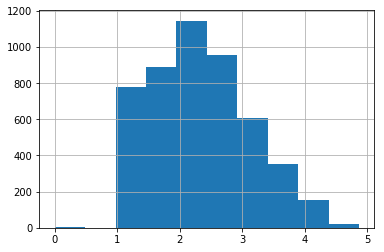

In [13]:
#Complex games are preferred
df['weight'].hist()

df['weight_bucket'] = pd.qcut(df['weight'],10)
cdf = df.groupby(['weight_bucket','avg_rating_range'])['game_id'].count().unstack()
cdf['NPS'] = cdf['promoters']/246 - cdf['detractors']/4657
#print cdf.sort_values('weight_bucket',ascending = True)
print cdf.sort_values('NPS',ascending = False)
#classics and younger games are loved by game lovers
cdf.to_csv("weight.csv")
cdf = df.groupby(['weight_bucket','geek_rating_range'])['game_id'].count().unstack()
cdf['NPS'] = cdf['promoters']/246 - cdf['detractors']/4657
#cdf.sort_values('weight_bucket',ascending = True)
print cdf.sort_values('NPS',ascending = False)

### Mechanic of the game

In [14]:
#Splitting string variables
#mechanic, category and designer features have text which is comma separated. Breaking them up into different features
df['mechanic_c'] = df['mechanic'].apply(lambda x: re.sub(r'[^\,\s\w]','',x))
games_mechanics= DataFrame(df['mechanic_c'].str.split(',').tolist(),index=df['avg_rating'])
games_mechanics = games_mechanics.reset_index()[[0, 'avg_rating']]
games_mechanics.columns = ['mechanic_c', 'avg_rating']

conditions = [
    (games_mechanics['avg_rating'] <= df['avg_rating'].quantile(0.95)),
    (games_mechanics['avg_rating'] > df['avg_rating'].quantile(0.95))]
choices = ['detractors', 'promoters']
games_mechanics['avg_rating_range'] = np.select(conditions, choices)
games_mechanics['avg_rating_range'].value_counts()

cdf = games_mechanics.groupby(['mechanic_c','avg_rating_range'])['avg_rating'].count().unstack()
cdf['NPS'] = cdf['promoters']/246 - cdf['detractors']/4657
print cdf.sort_values('NPS',ascending = False)[:10]
cdf.to_csv("mechanic_game.csv")

games_mechanics= DataFrame(df['mechanic_c'].str.split(',').tolist(),index=df['geek_rating'])
games_mechanics = games_mechanics.reset_index()[[0, 'geek_rating']]
games_mechanics.columns = ['mechanic_c', 'geek_rating']

conditions = [
    (games_mechanics['geek_rating'] <= df['geek_rating'].quantile(0.95)),
    (games_mechanics['geek_rating'] > df['geek_rating'].quantile(0.95))]
choices = ['detractors', 'promoters']
games_mechanics['geek_rating_range'] = np.select(conditions, choices)
games_mechanics['geek_rating_range'].value_counts()
cdf = games_mechanics.groupby(['mechanic_c','geek_rating_range'])['geek_rating'].count().unstack()
cdf['NPS'] = cdf['promoters']/246 - cdf['detractors']/4657
cdf.sort_values('NPS',ascending = False)[:10]


avg_rating_range               detractors  promoters       NPS
mechanic_c                                                    
Action Point Allowance System       334.0       35.0  0.070556
Dice Rolling                        585.0       43.0  0.049179
HexandCounter                       154.0       20.0  0.048232
Campaign  Battle Card Driven         84.0       14.0  0.038873
Action  Movement Programming        109.0       14.0  0.033505
Cooperative Play                    215.0       16.0  0.018874
ChitPull System                      39.0        6.0  0.016016
Area Enclosure                       45.0        6.0  0.014727
Deck  Pool Building                  92.0        7.0  0.008700
Variable Phase Order                  2.0        1.0  0.003636


geek_rating_range,detractors,promoters,NPS
mechanic_c,,,
Card Drafting,349.0,39.0,0.083596
Area Control Area Influence,502.0,45.0,0.075132
Action Point Allowance System,338.0,31.0,0.053437
Action Movement Programming,111.0,12.0,0.024945
Worker Placement,17.0,6.0,0.020740
Partnerships,62.0,6.0,0.011077
Area Enclosure,46.0,5.0,0.010448
Memory,42.0,4.0,0.007241
Cooperative Play,218.0,13.0,0.006034


### Category of Game

In [16]:
#Splitting string variables
#mechanic, category and designer features have text which is comma separated. Breaking them up into different features
df['category_c'] = df['category'].apply(lambda x: re.sub(r'[^\,\s\w]','',x))
games_mechanics= DataFrame(df['category_c'].str.split(',').tolist(),index=df['avg_rating'])
games_mechanics = games_mechanics.reset_index()[[0, 'avg_rating']]
games_mechanics.columns = ['category_c', 'avg_rating']

conditions = [
    (games_mechanics['avg_rating'] <= df['avg_rating'].quantile(0.95)),
    (games_mechanics['avg_rating'] > df['avg_rating'].quantile(0.95))]
choices = ['detractors', 'promoters']
games_mechanics['avg_rating_range'] = np.select(conditions, choices)
games_mechanics['avg_rating_range'].value_counts()
cdf = games_mechanics.groupby(['category_c','avg_rating_range'])['avg_rating'].count().unstack()
cdf['NPS'] = cdf['promoters']/246 - cdf['detractors']/4657
print cdf.sort_values('NPS',ascending = False)[:20]
top_20_categories = cdf.sort_values('NPS',ascending = False)[:20].index
cdf.to_csv("category_game.csv")
games_mechanics= DataFrame(df['category_c'].str.split(',').tolist(),index=df['geek_rating'])
games_mechanics = games_mechanics.reset_index()[[0, 'geek_rating']]
games_mechanics.columns = ['category_c', 'geek_rating']

conditions = [
    (games_mechanics['geek_rating'] <= df['geek_rating'].quantile(0.95)),
    (games_mechanics['geek_rating'] > df['geek_rating'].quantile(0.95))]
choices = ['detractors', 'promoters']
games_mechanics['geek_rating_range'] = np.select(conditions, choices)
games_mechanics['geek_rating_range'].value_counts()
cdf = games_mechanics.groupby(['category_c','geek_rating_range'])['geek_rating'].count().unstack()
cdf['NPS'] = cdf['promoters']/246 - cdf['detractors']/4657
cdf.sort_values('NPS',ascending = False)[:20]


avg_rating_range            detractors  promoters       NPS
category_c                                                 
Wargame                          188.0       39.0  0.118167
Adventure                        258.0       27.0  0.054356
Modern Warfare                    40.0       13.0  0.044256
Aviation  Flight                  82.0       12.0  0.031173
Economic                         299.0       23.0  0.029292
Napoleonic                        37.0        7.0  0.020510
Fantasy                          137.0       12.0  0.019362
Civilization                      62.0        7.0  0.015142
American Civil War                50.0        6.0  0.013654
American Indian Wars               1.0        3.0  0.011980
Civil War                         12.0        3.0  0.009618
Environmental                      9.0        2.0  0.006198
Sports                            13.0        2.0  0.005339
Negotiation                       15.0        2.0  0.004909
Miniatures                        38.0  

geek_rating_range,detractors,promoters,NPS
category_c,,,
Economic,285.0,37.0,0.089208
Adventure,258.0,27.0,0.054356
City Building,127.0,16.0,0.037770
Civilization,59.0,10.0,0.027981
Ancient,212.0,16.0,0.019518
Dice,153.0,12.0,0.015927
Trains,26.0,5.0,0.014742
Age of Reason,45.0,6.0,0.014727
Renaissance,12.0,4.0,0.013683


### Designer of Game

In [17]:
#designer
#Splitting string variables
df['designer_c'] = df['designer'].apply(lambda x: re.sub(r'[^\,\s\w]','',x))
games_mechanics= DataFrame(df['designer_c'].str.split(',').tolist(),index=df['avg_rating'])
games_mechanics = games_mechanics.reset_index()[[0, 'avg_rating']]
games_mechanics.columns = ['designer_c', 'avg_rating']

#creating promoter and detractor buckets for avg_rating
conditions = [
    (games_mechanics['avg_rating'] <= df['avg_rating'].quantile(0.95)),
    (games_mechanics['avg_rating'] > df['avg_rating'].quantile(0.95))]
choices = ['detractors', 'promoters']
games_mechanics['avg_rating_range'] = np.select(conditions, choices)
cdf = games_mechanics.groupby(['designer_c','avg_rating_range'])['avg_rating'].count().unstack()
cdf['NPS'] = cdf['promoters']/246 - cdf['detractors']/4657
print cdf.sort_values('NPS',ascending = False)[:20]
top_20_designers = cdf.sort_values('NPS',ascending = False)[:20].index

#Splitting string variables
games_mechanics= DataFrame(df['designer_c'].str.split(',').tolist(),index=df['geek_rating'])
games_mechanics = games_mechanics.reset_index()[[0, 'geek_rating']]
games_mechanics.columns = ['designer_c', 'geek_rating']

#creating promoter and detractor buckets for geek_rating
conditions = [
    (games_mechanics['geek_rating'] <= df['geek_rating'].quantile(0.95)),
    (games_mechanics['geek_rating'] > df['geek_rating'].quantile(0.95))]
choices = ['detractors', 'promoters']
games_mechanics['geek_rating_range'] = np.select(conditions, choices)
cdf = games_mechanics.groupby(['designer_c','geek_rating_range'])['geek_rating'].count().unstack()
cdf['NPS'] = cdf['promoters']/246 - cdf['detractors']/4657
cdf.sort_values('NPS',ascending = False)[:20]


avg_rating_range    detractors  promoters       NPS
designer_c                                         
Dean Essig                24.0       10.0  0.035497
John H Butterfield         4.0        5.0  0.019466
Vlaada Chvtil             15.0        5.0  0.017104
Adam Carlson               1.0        4.0  0.016045
Gene Billingsley           1.0        4.0  0.016045
Uwe Rosenberg             27.0        5.0  0.014527
Ed Beach                   1.0        3.0  0.011980
Adam Starkweather          2.0        3.0  0.011766
Ken Dunn                   2.0        3.0  0.011766
Vital Lacerda              3.0        3.0  0.011551
Mark Herman                9.0        3.0  0.010263
D Brad Talton             11.0        3.0  0.009833
Jens Drgemller             1.0        2.0  0.007915
Richard Sivl               1.0        2.0  0.007915
Uwe Eickert                2.0        2.0  0.007701
Jamey Stegmaier            2.0        2.0  0.007701
Hermann Luttmann           2.0        2.0  0.007701
Simone Lucia

geek_rating_range,detractors,promoters,NPS
designer_c,,,
Uwe Rosenberg,21.0,11.0,0.040206
Vlaada Chvtil,10.0,10.0,0.038503
Stefan Feld,18.0,7.0,0.024590
Vital Lacerda,2.0,4.0,0.015831
Mac Gerdts,6.0,4.0,0.014972
Corey Konieczka,7.0,4.0,0.014757
Richard Borg,13.0,4.0,0.013469
Antoine Bauza,15.0,4.0,0.013039
Jamey Stegmaier,1.0,3.0,0.011980


## Voter's ownership

In [ ]:
#ownership
#the more the number of people owning it, the critical the game gets
df['owned'].hist()
xlabel("Number of voters who own the board game")

print df['owned'].quantile([0,0.25,0.5,0.75,0.95,0.99,1])

df['owned_bucket'] = pd.qcut(df['owned'],3)
cdf = pd.crosstab(df['owned_bucket'],df['avg_rating_range']).apply(lambda c: (c/c.sum(axis=0))*100, axis=0)
cdf['NPS'] = cdf['promoters'] - cdf['detractors']
print cdf.sort_values('owned_bucket',ascending = True)

cdf = pd.crosstab(df['owned_bucket'],df['geek_rating_range']).apply(lambda c: (c/c.sum(axis=0))*100, axis=0)
cdf['NPS'] = cdf['promoters'] - cdf['detractors']
cdf.sort_values('owned_bucket',ascending = True)

## Number of votes

In [ ]:
#num_votes
#the more the number of votes, higher the number of promoters for it
df['num_votes'].hist()
xlabel("Number of voters")

df['num_votes_bucket'] = pd.qcut(df['num_votes'],10)
cdf = pd.crosstab(df['num_votes_bucket'],df['avg_rating_range']).apply(lambda c: (c/c.sum(axis=0))*100, axis=0)
cdf['NPS'] = cdf['promoters'] - cdf['detractors']
print cdf.sort_values('num_votes_bucket',ascending = True)
#classics and younger games are loved by game lovers

cdf = pd.crosstab(df['num_votes_bucket'],df['geek_rating_range']).apply(lambda c: (c/c.sum(axis=0))*100, axis=0)
cdf['NPS'] = cdf['promoters'] - cdf['detractors']
cdf.sort_values('num_votes_bucket',ascending = True)

### Penetration ratio

In [ ]:
import statsmodels.api as sm
from patsy import dmatrices

y, X = dmatrices('owned ~ num_votes', df, return_type='dataframe')
result = sm.OLS(y, X).fit()
slope = result.params['num_votes']
intercept = result.params['Intercept']
predicted = df['num_votes'] * slope + intercept
regression_predictions = Series(predicted.values,
                                index=df['num_votes'])

#owned is if user owns or not
plot(df['num_votes'],df['owned'],marker='o', color='red', linestyle='None')
regression_predictions.plot(label='Regression', linewidth=2)
legend(numpoints=1, loc='best')
xlabel('number of votes')
ylabel('Owned')
show()

In [ ]:
#Penetration ratio
# Higher the number of voters owning the game, better rating
df['penetration_ratio'] = df['owned'] / df['num_votes']
df['penetration_ratio'].hist()
xlabel("Penetration ratio")
print df['penetration_ratio'].quantile([0,0.25,0.5,0.75,0.95,0.99,1])

df['pen_ratio_bucket'] = pd.qcut(df['penetration_ratio'],10)
cdf = pd.crosstab(df['pen_ratio_bucket'],df['avg_rating_range']).apply(lambda c: (c/c.sum(axis=0))*100, axis=0)
cdf['NPS'] = cdf['promoters'] - cdf['detractors']
print cdf.sort_values('pen_ratio_bucket',ascending = True)
#classics and younger games are loved by game lovers

cdf = pd.crosstab(df['pen_ratio_bucket'],df['geek_rating_range']).apply(lambda c: (c/c.sum(axis=0))*100, axis=0)
cdf['NPS'] = cdf['promoters'] - cdf['detractors']
cdf.sort_values('pen_ratio_bucket',ascending = True)

### Age of the game

In [ ]:
df['age_game'] = 2018 - df['year']
print df['age_game'].quantile([0,0.25,0.5,0.75,0.95,0.99,1])
dfx = df[df['year']>0]

df['age_game_bucket'] = pd.qcut(df['age_game'],10)
cdf = df.groupby(['age_game_bucket','avg_rating_range'])['game_id'].count().unstack()
cdf['NPS'] = cdf['promoters']/246 - cdf['detractors']/4657
cdf.sort_values('age_game_bucket',ascending = True)


## Regression

Checking importance of variables:
<br> 1. num_players
<br> 2. avg_time
<br> 3. age (min age for playing the game)
<br> 4. weight (complexity of the game)
<br> 5. penetration_ratio (% of voters who own the game)
<br> 6. age_game (age of the game)

In [ ]:
import statsmodels.api as sm
from patsy import dmatrices

In [ ]:
y, X = dmatrices('avg_rating ~ num_players', data=df, return_type='dataframe')
model = sm.OLS(y, X) 
result = model.fit()
print 'Params'
print result.params
print
print 'R-squared =', (result.rsquared) * 100, "%"
print
print 'p-values'
print result.pvalues

In [ ]:
y, X = dmatrices('avg_rating ~ avg_time', data=df, return_type='dataframe')
model = sm.OLS(y, X) 
result = model.fit()
print 'Params'
print result.params
print
print 'R-squared =', (result.rsquared) * 100, "%"
print
print 'p-values'
print result.pvalues

In [ ]:
y, X = dmatrices('avg_rating ~ age', data=df, return_type='dataframe')
model = sm.OLS(y, X) 
result = model.fit()
print 'Params'
print result.params
print
print 'R-squared =', (result.rsquared) * 100, "%"
print
print 'p-values'
print result.pvalues

In [ ]:
y, X = dmatrices('avg_rating ~ weight', data=df, return_type='dataframe')
model = sm.OLS(y, X) 
result = model.fit()
print 'Params'
print result.params
print
print 'R-squared =', (result.rsquared) * 100, "%"
print
print 'p-values'
print result.pvalues

In [ ]:
y, X = dmatrices('avg_rating ~ penetration_ratio', data=df, return_type='dataframe')
model = sm.OLS(y, X) 
result = model.fit()
print 'Params'
print result.params
print
print 'R-squared =', (result.rsquared) * 100, "%"
print
print 'p-values'
print result.pvalues

In [ ]:
y, X = dmatrices('avg_rating ~ age_game', data=df, return_type='dataframe')
model = sm.OLS(y, X) 
result = model.fit()
print 'Params'
print result.params
print
print 'R-squared =', (result.rsquared) * 100, "%"
print
print 'p-values'
print result.pvalues

In [18]:
#category
def ret_cat(s):
    x = s.split(",")
    for i in x:
        if i.lstrip() in top_20_categories.tolist():
            return (1)
    return (0)
df['top_category'] = df['category_c'].map(ret_cat)
#df['top_category'].value_counts()

def ret_des(s):
    x = s.split(",")
    for i in x:
        if i.lstrip() in top_20_designers.tolist():
            return (1)
    return (0)
df['top_designer'] = df['designer_c'].map(ret_des)
df['top_designer'].value_counts()

0    4687
1     216
Name: top_designer, dtype: int64

In [ ]:
y, X = dmatrices('avg_rating ~ top_designer', data=df, return_type='dataframe')
model = sm.OLS(y, X) 
result = model.fit()
print 'Params'
print result.params
print
print 'R-squared =', (result.rsquared) * 100, "%"
print
print 'p-values'
print result.pvalues

In [ ]:
y, X = dmatrices('avg_rating ~ top_category', data=df, return_type='dataframe')
model = sm.OLS(y, X) 
result = model.fit()
print 'Params'
print result.params
print
print 'R-squared =', (result.rsquared) * 100, "%"
print
print 'p-values'
print result.pvalues

In [ ]:
y, X = dmatrices('avg_rating ~ top_category + top_designer + num_players + weight + avg_time_bucket + age', data=df, return_type='dataframe')
model = sm.OLS(y, X) 
result = model.fit()
print 'Params'
print result.params
print
print 'R-squared =', (result.rsquared) * 100, "%"
print
print 'p-values'
print result.pvalues

### Correlation plot

In [ ]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);

plot_corr(df)
df.corr().to_csv("correlation_plot.csv")

## Trees

Create popular and not popular based on 95th percentile of avg_rating
<br> Going to create dummy for top categories, mechanics and designer
<br> Other vars: avg_time, age, num_votes, min players, max players, pen ratio

In [19]:
from pandas import Series, DataFrame
import pandas as pd
from patsy import dmatrices
from sklearn.model_selection import train_test_split
import warnings
%pylab inline
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [20]:
df.columns.values

array(['rank', 'bgg_url', 'game_id', 'names', 'min_players',
       'max_players', 'avg_time', 'min_time', 'max_time', 'year',
       'avg_rating', 'geek_rating', 'num_votes', 'image_url', 'age',
       'mechanic', 'owned', 'category', 'designer', 'weight',
       'avg_rating_range', 'geek_rating_range', 'num_players', 'popular',
       'weight_bucket', 'mechanic_c', 'category_c', 'designer_c',
       'top_category', 'top_designer'], dtype=object)

In [21]:
df['popular'] = 1 * (df['avg_rating'] >=df['avg_rating'].quantile(0.75))
print df.columns.values
df['popular'].value_counts()
#df.to_csv("model_dataset.csv")

['rank' 'bgg_url' 'game_id' 'names' 'min_players' 'max_players' 'avg_time'
 'min_time' 'max_time' 'year' 'avg_rating' 'geek_rating' 'num_votes'
 'image_url' 'age' 'mechanic' 'owned' 'category' 'designer' 'weight'
 'avg_rating_range' 'geek_rating_range' 'num_players' 'popular'
 'weight_bucket' 'mechanic_c' 'category_c' 'designer_c' 'top_category'
 'top_designer']


0    3677
1    1226
Name: popular, dtype: int64

In [22]:
Y, X = dmatrices('popular ~  0  + top_category + top_designer + num_players + avg_time + age + weight', df, return_type='dataframe')
#Y, X = dmatrices('avg_rating ~ 0  + top_category + top_designer + num_players + avg_time + age + weight', df, return_type='dataframe')
y = Y['popular'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) #random_state is seed
X[:5]

,num_players[a],num_players[b],num_players[c],num_players[d],num_players[f],num_players[g],num_players[h],num_players[i],num_players[j],num_players[k],num_players[l],num_players[single_player],num_players[two_player],top_category,top_designer,avg_time,age,weight
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,150.0,12.0,3.7720
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,60.0,13.0,2.8056
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,240.0,14.0,4.3538
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,180.0,13.0,3.5446
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,120.0,12.0,3.2465


In [23]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn import metrics
from sklearn import tree

# Create the folds in the training data
kfold = StratifiedKFold(n_splits=10, shuffle=True)

# Iterate over max_depth
for max_depth in [1, 2, 3, 4, 5]:
    model3 = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    scores = cross_val_score(model3, X_train, y_train, cv=kfold)
    print 'max_depth={} scores={} avg_score={}'.format(max_depth, scores, scores.mean())

max_depth=1 scores=[0.74709302 0.74709302 0.74709302 0.74709302 0.74709302 0.74709302
 0.74853801 0.74853801 0.74853801 0.74853801] avg_score=0.747671018632
max_depth=2 scores=[0.79651163 0.78488372 0.79360465 0.75872093 0.77616279 0.78488372
 0.75730994 0.7748538  0.7748538  0.78654971] avg_score=0.778833469332
max_depth=3 scores=[0.77034884 0.80523256 0.76744186 0.76453488 0.77616279 0.80813953
 0.7748538  0.7748538  0.78362573 0.75438596] avg_score=0.777957976336
max_depth=4 scores=[0.78488372 0.77034884 0.79069767 0.77325581 0.80232558 0.77325581
 0.79824561 0.7748538  0.77192982 0.77777778] avg_score=0.78175744594
max_depth=5 scores=[0.79069767 0.78488372 0.79651163 0.79360465 0.79360465 0.80232558
 0.75730994 0.78362573 0.80116959 0.74853801] avg_score=0.785227118183


In [33]:
model = tree.DecisionTreeClassifier(criterion='entropy',max_depth=3)

result = model.fit(X_train, y_train)

prediction_train = model.predict(X_train)
print metrics.accuracy_score(y_train, prediction_train)

prediction = model.predict(X_test)
print metrics.accuracy_score(y_test, prediction)
#DataFrame(X_test, prediction).to_csv("prediction.csv")
print len(prediction[prediction==1])
print len(prediction[prediction==1])/(1226 *1.0)

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, prediction)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8554778554778555
0.7804214819850442
271
0.221044045677


0.6612336233623363

In [37]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X.columns.values)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()).write_png('tree_small.png')
#Image(graph.create_png())

In [36]:
from StringIO import StringIO
import pydot_ng
dot_data = StringIO()

tree.export_graphviz(model, out_file=dot_data, feature_names=X.columns.values)
pydot_ng.graph_from_dot_data(dot_data.getvalue()).write_png('tree_big.png')

True

In [32]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

model2 = tree.DecisionTreeClassifier(criterion='entropy',max_depth=10)
result = model.fit(X_train, y_train)
dot_data = StringIO()
export_graphviz(model2, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X.columns.values)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.